In [1]:
import numpy as np
import cv2
import time
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def read_img(file):
    img_feat_list,label_list = [],[]
    with open(file) as f:
        for i in f:
            img_info = i.split(" ")
            img_name = img_info[0]
            img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(32, 32))
            img_feat = img/255.0
            img_feat_list.append(img_feat)
            
            label = int(img_info[-1])
            label_onehot = np.zeros(50)
            label_onehot[label] = 1
            label_list.append(label_onehot)
    return np.array(img_feat_list),np.array(label_list)

In [3]:
%%time
train_feat,train_label = read_img("train.txt")
val_feat,val_label = read_img("val.txt")
test_feat,test_label = read_img("test.txt")

CPU times: total: 37.8 s
Wall time: 38.7 s


# Reference：[LeNet5 from scratch](https://github.com/chuanqi305/LeNet5)

## Trainable : 定義訓練時使用的參數

In [4]:
class Trainable(object):
    learning_rate = 0.0003
    learning_rate_decay = 0.001
    momentum = 0.95
    epoch = 25
    batch_size = 32
    weight_decay = 0.001

    def __init__(self):
        self.weight_diff = 0
        self.bias_diff = 0

    def sgd_momentum(self, weight_diff, bias_diff):
        self.weight_diff = self.momentum * self.weight_diff + (1 - self.momentum) * weight_diff
        self.bias_diff = self.momentum * self.bias_diff + (1 - self.momentum) * bias_diff
        return self.weight_diff, self.bias_diff

## Convolution (kernel size 為 $5 \times 5$)

- forward

輸入矩陣後，取出和 kernel 大小相等的 submatrix。將 submatrix 壓成 $1 \times n$ 的向量、kernel 壓成 $n \times 1$ 的向量，兩個向量內積後就是 convolution的值。下方是示意圖：

![conv](conv.png)

這裡的 convolution 計算可以一次輸入多張影像同時計算，且只有兩層迴圈，計算會比較快。


- backward

參考資料：[Backpropagarion for Convolution](https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c)

    - 第一個 for loop：計算 weight difference
    
        這一層的 weight difference，恰好為「 forward 的 input 」 與 「 upstream gradient 」 做 convolution 的結果


    - 第二個 for loop：計算要繼續 backpropagation 的 gradient
    
        先將 upstream gradient 做 padding， 再將 kernel 旋轉180度。要繼續往回傳的 gradient 恰好為 「旋轉後的 kernel」 與 「 padding 過的 upstream gradient 」 做 convolution 的結果

In [5]:
class Conv(Trainable):
    def __init__(self, name, kernel, inc, outc):
        super(Conv, self).__init__()
        self.name = name
        self.kernel = kernel
        self.inc = inc
        self.outc = outc
        self.weight = np.random.randn(kernel, kernel, inc, outc) * np.sqrt(2.0 / (kernel * kernel * inc)) #msra
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.x = x
        k = self.kernel
        n, h, w, c = x.shape
        h_out = h - (k - 1)
        w_out = w - (k - 1)
        weight = self.weight.reshape(-1, self.outc)
        output = np.zeros((n, h_out, w_out, self.outc))
        for i in range(h_out):
            for j in range(w_out):
                inp = x[:, i:i+k, j:j+k, :].reshape(n, -1)
                out = inp.dot(weight) + self.bias
                output[:, i, j, :] = out.reshape(n, -1)
        return output

    def backward(self, diff):
        n, h, w, c = diff.shape
        k = self.kernel
        h_in = h + (k - 1)
        w_in = w + (k - 1)

        weight_diff = np.zeros((k, k, self.inc, self.outc))
        for i in range(k):
            for j in range(k):
                #inp = (n, 28, 28, c) => (n*28*28, c) => (c, n*28*28)
                inp = self.x[:, i:i+h, j:j+w, :].reshape(-1, self.inc).T
                #diff = n, 28, 28, 6 => (n*28*28, 6)
                diff_out = diff.reshape(-1, self.outc)
                weight_diff[i, j, :, :] = inp.dot(diff_out)
        bias_diff = np.sum(diff, axis=(0, 1, 2))

        pad = k - 1
        diff_pad = np.pad(diff, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant')
        rotated_weight = self.weight[::-1, ::-1, :, :].transpose(0, 1, 3, 2).reshape(-1, self.inc)
        back_diff = np.zeros((n, h_in, w_in, self.inc))
        for i in range(h_in):
            for j in range(w_in):
                diff_out = diff_pad[:, i:i+k, j:j+k, :].reshape(n, -1)
                out = diff_out.dot(rotated_weight)
                back_diff[:, i, j, :] = out.reshape(n, -1)
        # update weight and bias
        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias

        return back_diff

## Pooling (在此 kernel size, stride 皆預設為 2)

- forward

這裡的作法是將輸入矩陣的寬度與高度先除以2，再沿著第1與第3個軸的方向尋找最大值，以下是範例圖(紅色方形圍起來的部分為最大值)：

![pool](pool2.png)

這裡的 pooling 計算只需要將影像的寬度與高度分別除以2，沿著對應的維度取最大值即可達成。但遇到寬度高度的維度為奇數時，需要另外做 padding 或用 stride (在 improved LeNet5 使用 zero padding)

mask 用於判斷 pooling 後的結果在原始矩陣的位置，True 表示該位置的數值為 pooling 後的最大值

- backward

參考資料：[Backpropagation for maxpooling](https://mukulrathi.com/demystifying-deep-learning/conv-net-backpropagation-maths-intuition-derivation/)

利用 forward 時儲存的 mask ，將 upstream gradient 與 mask 做相乘後，再將 feature map 的寬度與高度乘以2倍，還原維度

In [6]:
class Pooling():
    def forward(self, x):
        n, h, w, c = x.shape
        x_grid = x.reshape(n, h // 2, 2, w // 2, 2, c)
        out = np.max(x_grid, axis=(2, 4))
        self.mask = (out.reshape(n, h // 2, 1, w // 2, 1, c) == x_grid)
        return out

    def backward(self, diff):
        n, h, w, c = diff.shape
        diff_grid = diff.reshape(n, h, 1, w, 1, c)
        return (diff_grid * self.mask).reshape(n, h * 2, w * 2, c)

## Activation function

原始作者使用 relu 作為 activation function, 這裡配合論文，改用 sigmoid  


![sigmoid](sigmoid.png)

In [7]:
class sigmoid():
    def __init__(self):
        pass
    def forward(self,x):
        self.x = x
        self.x1 = -self.x
        self.x2 = np.exp(self.x1)
        self.x3 = 1 + self.x2
        output = 1 / self.x3
        return output
    def backward(self,upg): # upg:upstream gradient
        gd3 = upg * (-1 / (self.x3)**2)
        gd2 = gd3 * 1
        gd1 = gd2 * np.exp(self.x1)
        gd0 = gd1 * -1
        return gd0
# class ReLU():
#     def forward(self, x):
#         self.x = x
#         return (x > 0) * x

#     def backward(self, diff):
#         return (self.x > 0) * diff


## Fully connect layer

![fc](fc.png)

In [8]:
class FC(Trainable):
    def __init__(self, name, inc, outc):
        super(FC, self).__init__()
        self.name = name
        self.weight = np.random.randn(inc, outc) * np.sqrt(2.0 / inc) #msra
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.origin_shape = x.shape
        if x.ndim == 4:
            x = x.reshape(x.shape[0], -1)
        self.x = x
        return x.dot(self.weight) + self.bias
   
    def backward(self, diff):
        #diff = (n, 10)
        #self.x = (n, 1024) => (1024, n)
        weight_diff = self.x.T.dot(diff)
        bias_diff = np.sum(diff, axis=0)
        #weight = (1024, 10) => (10, 1024), back_diff = (n, 1024)
        back_diff = diff.dot(self.weight.T).reshape(self.origin_shape)

        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias
        return back_diff

## Softmax

- forward

使用 softmax，將最後一層 fully connected layer 的輸出轉為影像分別屬於第 1~50 個類別的機率。  

- backward

在計算 backpropagation 時，根據推導的結果，回傳的數值恰好為 「預測的機率值」與「真實label的 one-hot matrix」做相減。

參考資料：[Derivative of softmax](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)

In [9]:
class SoftmaxLoss():
    def forward(self, x):
        softmax = np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
        self.softmax = softmax
        # output = np.argmax(softmax, axis=1)
        if not hasattr(self, 'y'):
            return softmax
        y = self.y
        label = np.argmax(y, axis=1)
        loss = -np.sum(y * np.log(softmax) + (1 - y) * np.log(1 - softmax))
        # accuracy = np.sum(output==label) / float(len(label))
        accuracy = (softmax.argmax(1) == label).sum()
        accuracy_top5 = len([i for i in range(len(label)) if label[i] in np.argsort(-softmax,axis=1)[i,:5]])
        return loss, accuracy, accuracy_top5

    def backward(self, diff):
        return self.softmax - self.y

    def set_label(self, label):
        self.y = label

## 模型的架構

這裡改寫了 training function，可以在訓練完後直接做 validation

In [23]:
class LeNet:
    def __init__(self):
        conv1 = Conv("conv1", 5, 1, 6)
        pool1 = Pooling()
        sigmoid1 = sigmoid()
        conv2 = Conv("conv2", 5, 6, 16)
        pool2 = Pooling()
        sigmoid2 = sigmoid()
        fc3 = FC("fc3", 5*5*16, 120)
        sigmoid3 = sigmoid()
        fc4 = FC("fc4", 120, 84)
        sigmoid4 = sigmoid()
        fc5 = FC("fc5", 84, 50)
        loss = SoftmaxLoss()
        self.layers = [conv1, pool1, sigmoid1, conv2, pool2, sigmoid2, fc3, sigmoid3, fc4, sigmoid4, fc5, loss]

    def train(self, train_images, train_labels, val_images, val_labels):
        
        batch_size = Trainable.batch_size
        train_index = np.arange(train_images.shape[0])
        val_index = np.arange(val_images.shape[0])
        train_num_batch = len(train_index)//batch_size
        val_num_batch = len(val_index)//batch_size
        train_acc, train_loss = [],[]
        val_acc, val_loss = [],[]
        for i in tqdm(range(Trainable.epoch)):
            random.shuffle(train_index)
            train_images = train_images[train_index]
            train_labels = train_labels[train_index]
            total_train_acc, total_train_loss = 0,0,
            for j in range(train_num_batch):
                x = train_images[j*batch_size : (j+1)*batch_size]
                y = train_labels[j*batch_size : (j+1)*batch_size]
            # x = images[index:index + batch_size] #mini batch sgd
            # y = labels[index:index + batch_size]
            # index += batch_size
            # index = index % len(images)

                loss = self.layers[-1]
                loss.set_label(y)

                for layer in self.layers:
                    # print(x.shape)
                    x = layer.forward(x)
                # collect loss,accuracy from each mini batch
                total_train_loss += x[0]
                total_train_acc += x[1]
                
                # if (j+1)%200 == 0:
                #     print("step %d: loss=%.6f, accuracy=%.4f, lr=%g" % (j+1, x[0]/batch_size, x[1]/batch_size, Trainable.learning_rate))
                
                diff = 1.0
                for layer in reversed(self.layers):
                    diff = layer.backward(diff)
                Trainable.learning_rate *= (1 - Trainable.learning_rate_decay)
                
            train_loss.append(total_train_loss/len(train_labels))
            train_acc.append(total_train_acc/len(train_labels))
            
            
            
            del loss.y
            
            total_val_acc, total_val_loss = 0,0
            for j in range(val_num_batch):
                x = val_images[j*batch_size : (j+1)*batch_size]
                y = val_labels[j*batch_size : (j+1)*batch_size]
                for layer in self.layers:
                    x = layer.forward(x)

                loss_value = -np.sum(y * np.log(x) + (1 - y) * np.log(1 - x))
                total_val_loss += loss_value
                label = np.argmax(y, axis=1)
                acc = (x.argmax(1) == label).sum()
                total_val_acc += acc
            val_loss.append(total_val_loss/len(val_labels))
            val_acc.append(total_val_acc/len(val_labels))
                
                
        return train_loss, train_acc, val_loss, val_acc
    def predict(self, images):
        x = images
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def save(self, path):
        model = {}
        for layer in self.layers:
            if isinstance(layer, Trainable):
                model[layer.name] = {"w": layer.weight, "b": layer.bias}
        np.save(path, model)

    def load(self, path):
        model = np.load(path, allow_pickle=True).item()
        for layer in self.layers:
            if isinstance(layer, Trainable):
                layer.weight = model[layer.name]["w"]
                layer.bias = model[layer.name]["b"]
    

## Training and Testing

In [24]:
%%time
lenet = LeNet()
train_result = lenet.train(np.expand_dims(train_feat,axis=3), train_label, np.expand_dims(val_feat,axis=3), val_label)

100%|██████████| 25/25 [29:28<00:00, 70.76s/it]

CPU times: total: 45min 33s
Wall time: 29min 28s


In [25]:
# val accuracy for top1
np.array(train_result[3]).mean(),np.array(train_result[3]).std()

(0.016977777777777776, 0.0020732273403894406)

Text(0, 0.5, 'Accuracy')

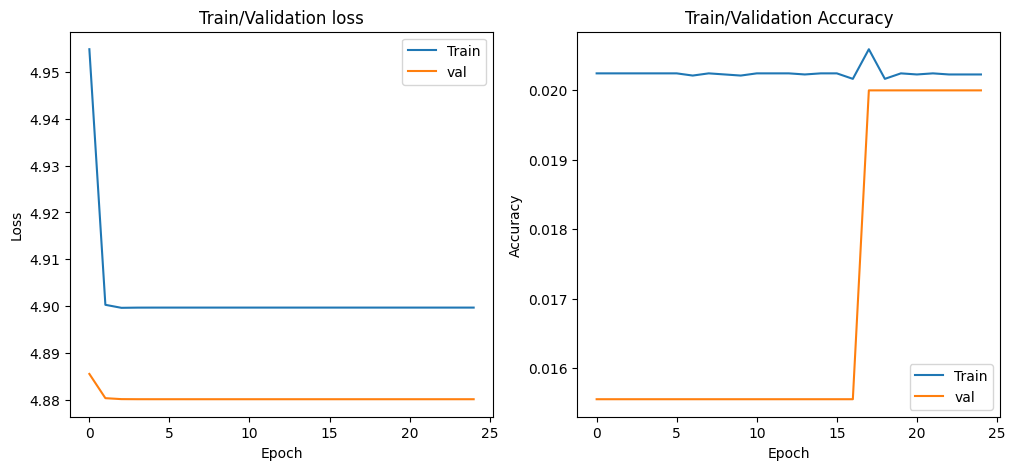

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(train_result[0], label="Train")
plt.plot(train_result[2], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation loss")

plt.subplot(122)
plt.plot(train_result[1], label="Train")
plt.plot(train_result[3], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")

In [32]:
# save the model and load to predict testing set
lenet.save("./HW3_best_model_handcraft")
mod = LeNet()
mod.load("./HW3_best_model_handcraft.npy")

In [34]:
total_test_acc = 0
total_test_acc_top5 = 0
test_index = np.arange(len(test_label))
test_num_batch = len(test_index)//32
inference_time = 0
for data in tqdm(range(test_num_batch)):
    test_batch_img = test_feat[data*32 : (data+1)*32]
    test_batch_label = test_label[data*32 : (data+1)*32]

    st_time = time.perf_counter()
    output = mod.predict(np.expand_dims(test_batch_img,axis=3))
    ed_time = time.perf_counter()
    inference_time += (ed_time - st_time)
    
    test_correct = (output.argmax(1) == test_batch_label.argmax(1)).sum()
    total_test_acc += test_correct
    label = test_batch_label.argmax(1)

print("Test top1 accuracy:{}".format(total_test_acc/len(test_index)))
print("Test inference time:{}s".format(inference_time))

100%|██████████| 14/14 [00:00<00:00, 85.59it/s]

Test top1 accuracy:0.02
Test inference time:0.16308310000204074s


In [57]:
mod

In [ ]:
# lenet.predict(np.expand_dims(test_feat,axis=3))
# tp = np.sum(pred == test_label)
# accuracy = float(tp) / len(test_label)
# accuracy

In [ ]:
# class conv():
#     def __init__(self,kernel_size):
#         self.size = kernel_size
#         self.weight = np.random.randn(kernel_size,kernel_size)
#     def forward(self,x): # x: number of image, number of channel, image height, image width
#         num_img, num_cha, height, width = x.shape
#         pool_height = height - self.size + 1
#         pool_width = width - self.size + 1
#         output = np.zeros((pool_height,pool_width))
#         for i in range(num_img):
#             for j in range(num_cha):
#                 for k in range(pool_height):
#                     for l in range(pool_width):
#                         output[k,l] = np.sum(x[i,j,k:k+self.size,l:l+self.size] * self.weight)

In [ ]:
# class maxpool():
#     def __init__(self,kernel_size):
#         self.size = kernel_size
#     def forward(self,x): # x: number of image, number of channel, image height, image width
#         num_img, num_cha, height, width = x.shape
#         pool_height = height - self.size + 1
#         pool_width = width - self.size + 1
#         output = np.zeros((num_img,num_cha,pool_height,pool_width))
#         for i in range(num_img):
#             for j in range(num_cha):
#                 for k in range(pool_height):
#                     for l in range(pool_width):
#                         output[i,j,k,l] = x[i,j,k:k+self.size,l:l+self.size].max()


In [ ]:
# class crossentropy(): # softmax->neg log likelihood
#     def __init__(self):
#         self.softmax = softmax()
#     def forward(self,pred,gt):
#         pred = self.softmax.forward(pred)
#         loss = self.negloglike(pred,gt)
#         return loss

#     def negloglike(self,pred,gt):
#         loss_matrix = np.sum(gt * np.log(pred),axis=1)
#         loss_sum = round(-sum(loss_matrix),5)
#         return loss_sum/len(pred)

In [ ]:
# class LeNet5(Net):
#     # LeNet5

#     def __init__(self):
#         self.conv1 = Conv(1, 6, 5)
#         self.ReLU1 = ReLU()
#         self.pool1 = MaxPool(2,2)
#         self.conv2 = Conv(6, 16, 5)
#         self.ReLU2 = ReLU()
#         self.pool2 = MaxPool(2,2)
#         self.FC1 = FC(16*4*4, 120)
#         self.ReLU3 = ReLU()
#         self.FC2 = FC(120, 84)
#         self.ReLU4 = ReLU()
#         self.FC3 = FC(84, 10)
#         self.Softmax = Softmax()

#         self.p2_shape = None

#     def forward(self, X):
#         h1 = self.conv1._forward(X)
#         a1 = self.ReLU1._forward(h1)
#         p1 = self.pool1._forward(a1)
#         h2 = self.conv2._forward(p1)
#         a2 = self.ReLU2._forward(h2)
#         p2 = self.pool2._forward(a2)
#         self.p2_shape = p2.shape
#         fl = p2.reshape(X.shape[0],-1) # Flatten
#         h3 = self.FC1._forward(fl)
#         a3 = self.ReLU3._forward(h3)
#         h4 = self.FC2._forward(a3)
#         a5 = self.ReLU4._forward(h4)
#         h5 = self.FC3._forward(a5)
#         a5 = self.Softmax._forward(h5)
#         return a5

#     def backward(self, dout):
#         #dout = self.Softmax._backward(dout)
#         dout = self.FC3._backward(dout)
#         dout = self.ReLU4._backward(dout)
#         dout = self.FC2._backward(dout)
#         dout = self.ReLU3._backward(dout)
#         dout = self.FC1._backward(dout)
#         dout = dout.reshape(self.p2_shape) # reshape
#         dout = self.pool2._backward(dout)
#         dout = self.ReLU2._backward(dout)
#         dout = self.conv2._backward(dout)
#         dout = self.pool1._backward(dout)
#         dout = self.ReLU1._backward(dout)
#         dout = self.conv1._backward(dout)

#     def get_params(self):
#         return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

#     def set_params(self, params):
#         [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params